<a href="https://colab.research.google.com/github/manola1109/-Emergency-vs-Non-Emergency-Vehicle-Image-Denoising/blob/main/Emergency_vs_Non_Emergency_Vehicle_Image_Denoising_(Autoencoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install & Import required libraries
!pip install matplotlib numpy tensorflow

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip //content/drive/MyDrive/image_denoising_dataset-200512-163438.zip

Archive:  //content/drive/MyDrive/image_denoising_dataset-200512-163438.zip
   creating: test/
  inflating: test/6934.jpg           
  inflating: test/2932.jpg           
  inflating: test/5893.jpg           
  inflating: test/2989.jpg           
  inflating: test/7967.jpg           
  inflating: test/5426.jpg           
  inflating: test/7219.jpg           
  inflating: test/8019.jpg           
  inflating: test/2393.jpg           
  inflating: test/7044.jpg           
  inflating: test/8962.jpg           
  inflating: test/8630.jpg           
  inflating: test/7068.jpg           
  inflating: test/4675.jpg           
  inflating: test/7453.jpg           
  inflating: test/8514.jpg           
  inflating: test/6103.jpg           
  inflating: test/5479.jpg           
  inflating: test/3442.jpg           
  inflating: test/8527.jpg           
  inflating: test/4716.jpg           
  inflating: test/8346.jpg           
  inflating: test/4835.jpg           
  inflating: test/6932.jpg     

In [5]:
clean_images_dir = '/content/drive/MyDrive/vehicle_dataset/clean_images'
noisy_images_dir = '/content/drive/MyDrive/vehicle_dataset/noisy_images'
test_images_dir = '/content/drive/MyDrive/vehicle_dataset/test_images'

In [6]:
def load_images_from_folder(folder, img_size=(128,128)):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(os.path.join(folder, filename), target_size=img_size)
            img = img_to_array(img)
            img = img / 255.0
            images.append(img)
    return np.array(images), filenames

In [9]:
!ls /content/

drive  sample_data  test  train


In [11]:
# Update the directory paths to reflect where the dataset was actually extracted
# Based on the !ls /content/ output, the dataset seems to be extracted into 'train' and 'test' folders
clean_images_dir = '/content/sample_data'
noisy_images_dir = '/content/sample_data'
test_images_dir = '/content/sample_data' # This path might need adjustment depending on the actual structure

# It is a good practice to check if the directories exist after defining the paths
import os
print(f"Clean images directory exists: {os.path.exists(clean_images_dir)}")
print(f"Noisy images directory exists: {os.path.exists(noisy_images_dir)}")
print(f"Test images directory exists: {os.path.exists(test_images_dir)}")

# If any of these print False, you might need to inspect the contents of /content/train/ and /content/test/
# using commands like !ls /content/train/ and !ls /content/test/ to confirm the exact subfolder names.

Clean images directory exists: True
Noisy images directory exists: True
Test images directory exists: True


In [15]:
X_noisy, noisy_fnames = load_images_from_folder('/content/train/noisy')
Y_clean, clean_fnames = load_images_from_folder('/content/train/clean')

In [16]:
print('Noisy images:', X_noisy.shape)
print('Clean images:', Y_clean.shape)

Noisy images: (1999, 128, 128, 3)
Clean images: (1999, 128, 128, 3)


In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X_noisy, Y_clean, test_size=0.15, random_state=42)

In [18]:
input_img = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,939 (54.45 KB)

 Trainable params: 13,939 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = autoencoder.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val, Y_val)
)

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0604 - val_loss: 0.0292
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0289 - val_loss: 0.0250
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0253 - val_loss: 0.0239
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0243 - val_loss: 0.0221
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0220 - val_loss: 0.0204
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0207 - val_loss: 0.0198
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0201 - val_loss: 0.0195
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0198 - val_loss: 0.0193
Epoch 9/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0194 - val_loss: 0.0189
Epoch 10/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 11/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 12/30
107/107 ━━━━━━━━━━━━━━━━━━━━

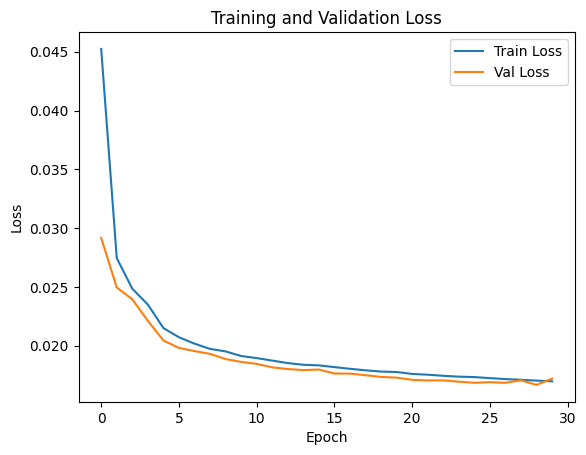

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


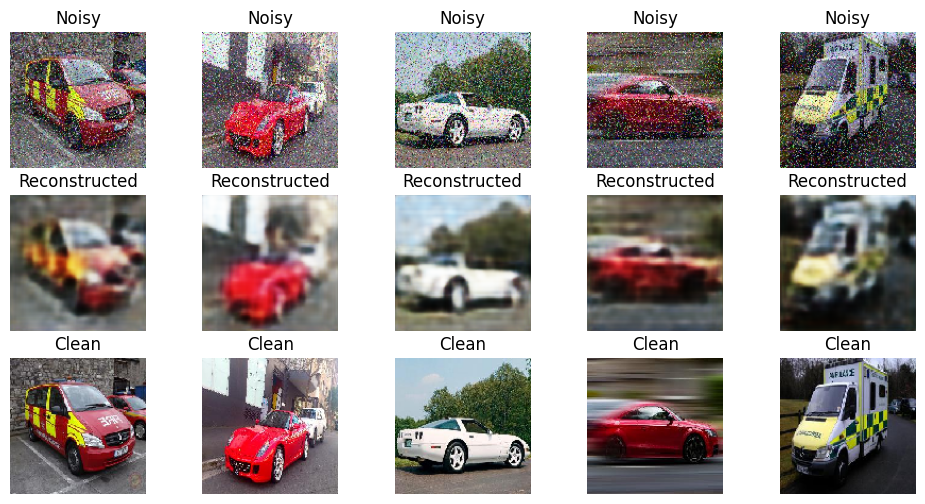

In [21]:
n = 5
decoded_imgs = autoencoder.predict(X_val[:n])
plt.figure(figsize=(12,6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_val[i])
    plt.title("Noisy")
    plt.axis('off')
    # Denoised output
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')
    # Clean target
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(Y_val[i])
    plt.title("Clean")
    plt.axis('off')
plt.show()

In [30]:
test_imgs, test_filenames = load_images_from_folder('/content/test')
reconstructed = autoencoder.predict(test_imgs)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [31]:
output_dir = '/content/drive/MyDrive/vehicle_dataset/reconstructed_test_images'
os.makedirs(output_dir, exist_ok=True)
for i in range(len(test_imgs)):
    plt.imsave(os.path.join(output_dir, f'reconstructed_{test_filenames[i]}'), reconstructed[i])

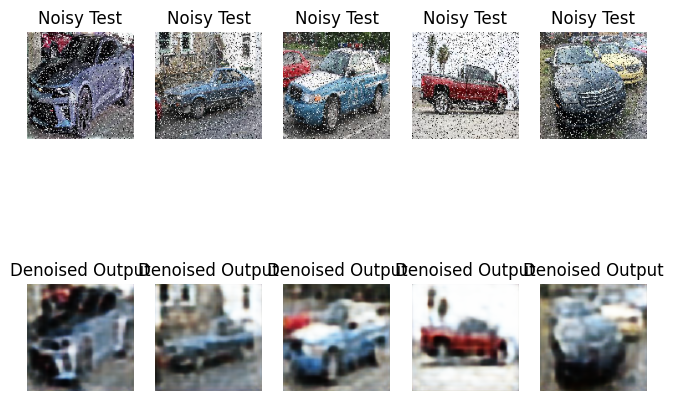

In [32]:
n = 5
plt.figure(figsize=(8,6))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_imgs[i])
    plt.title("Noisy Test")
    plt.axis('off')
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(reconstructed[i])
    plt.title("Denoised Output")
    plt.axis('off')
plt.show()